In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
data_path = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/sample_table.parquet"
df = pd.read_parquet(data_path)
print(f"{df.shape=}")
df.head()

df.shape=(94783588, 4)


,cell_id,gene,value,prob
0,HSC_7803,DDX11L1,3.0,2.218226e-09
1,HSC_7865,DDX11L1,1.0,7.394086e-10
2,HSC_7892,DDX11L1,2.0,1.478817e-09
3,HSC_7912,DDX11L1,17.0,1.256995e-08
4,FB_23149,DDX11L1,1.0,7.394086e-10


In [5]:
data_path = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/top_HSC_markers.csv"
mdf = pd.read_csv(data_path)
print(f"{mdf.shape=}")
mdf.head()

mdf.shape=(103, 6)


,names,scores,logfoldchanges,pvals,pvals_adj,perc
0,ARHGDIB,44.373740,4.412849,0.000000e+00,0.000000e+00,0.978947
1,GMFG,44.496376,8.757190,0.000000e+00,0.000000e+00,0.952632
2,CD74,40.044230,4.569716,0.000000e+00,0.000000e+00,0.944737
3,VAMP8,41.570374,6.812530,0.000000e+00,0.000000e+00,0.898684
4,STMN1,37.602573,4.165506,1.951229e-309,1.148689e-306,0.871053


In [76]:
def sample_rows(df, n):
    """a function to sample reads from a suingle-cell distribution """
    p = df['prob'].to_numpy()
    p /= p.sum() # normalized
    idx = np.random.choice(df.index, n, replace=False, p=p)

    return df.iloc[idx].reset_index(drop=True)


n = 100000
sdf = sample_rows(df, n)
sdf = sdf.reset_index(drop=False)
sdf = sdf.rename(columns={'index' : 'read_order'})
sdf['celltype'] = sdf['cell_id'].apply(lambda x: x.split("_")[0])
sdf.head()

,read_order,cell_id,gene,value,prob,celltype
0,0,FB_18596,MALAT1,476.0,3.519583e-07,FB
1,1,FB_21425,EFEMP1,1529.0,1.130555e-06,FB
2,2,HSC_7911,MT-RNR1,6984.0,5.164026e-06,HSC
3,3,HSC_7916,EEF1A1,34282.0,2.534839e-05,HSC
4,4,FB_27183,RPN1,113.0,8.355312e-08,FB


In [77]:
# get the markers
sdf['is_marker'] = np.where(sdf['gene'].isin(mdf['names']), 1, 0)
print(sdf['is_marker'].value_counts(normalize=True))

# get the first time point each read is
query = sdf[sdf['is_marker'] == 1][['read_order', 'cell_id']]
query = query.groupby('cell_id')['read_order'].min()

def mark_read(r, q):
    """A lambda apply function where `r` is 
    the read and `q` is the query """
    if r['cell_id'] in q.index:
        min_order = q.loc[r['cell_id']]
        if r['read_order'] >= min_order:
            return 1
        else:
            return 0
    else:
        return 0
        

sdf['accept'] = sdf.apply(lambda x: mark_read(x, query), axis=1 )
print(sdf['accept'].value_counts(normalize=True))
sdf.head()

0    0.99366
1    0.00634
Name: is_marker, dtype: float64
0    0.83893
1    0.16107
Name: accept, dtype: float64


,read_order,cell_id,gene,value,prob,celltype,is_marker,accept
0,0,FB_18596,MALAT1,476.0,3.519583e-07,FB,0,0
1,1,FB_21425,EFEMP1,1529.0,1.130555e-06,FB,0,0
2,2,HSC_7911,MT-RNR1,6984.0,5.164026e-06,HSC,0,0
3,3,HSC_7916,EEF1A1,34282.0,2.534839e-05,HSC,0,0
4,4,FB_27183,RPN1,113.0,8.355312e-08,FB,0,0


In [78]:
accepted_reads = sdf[sdf['accept'] == 1]
accepted_reads['celltype'].value_counts()

HSC    13926
FB      2181
Name: celltype, dtype: int64

<AxesSubplot: xlabel='read_order', ylabel='cum_accept'>

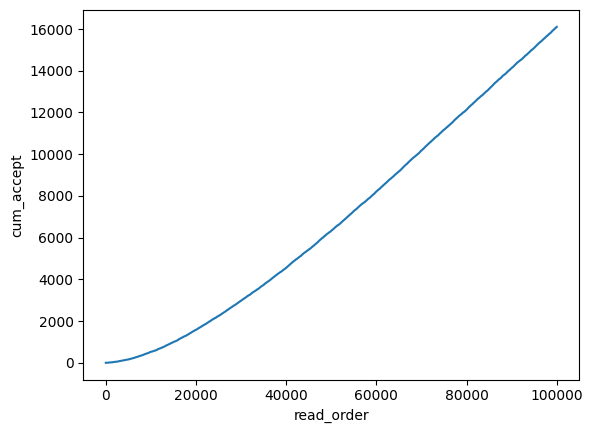

In [79]:
pdf = sdf.copy()
pdf['cum_accept'] = pdf['accept'].cumsum()

sns.lineplot(data=pdf, 
             x='read_order',
             y='cum_accept',)